# Early Warning System for Student Churn: A Data-Driven Approach

## Executive Summary

Built an Early Warning System for an Online University that identifies at-risk students by Week 4 with 70% precision. Discovered that behavioral 'momentum' (Relative Engagement) is a 5x stronger predictor of success than student demographics.

## Key Insights (The 'Aha!' Moments)

- **The Week 0 Gap**: Early engagement is critical.
- **Consistency > Volume**: Regular study habits outweigh cramming.
- **Social Connectivity**: Peer interaction is a strong retention signal.

## Technical Stack
- **Data Handling**: Pandas (Chunking for 10M+ rows), NumPy.
- **Machine Learning**: Random Forest Classifier, Scikit-Learn.
- **Visualizations**: Matplotlib/Seaborn.

# Phase 1: Environment Setup & Data Loading

## 1. Environment Setup
Importing necessary libraries.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## 2. Load Data
Defining the path to the datasets and loading OULAD CSV files.

In [10]:
# Define the path to the datasets
DATA_PATH = '../data/Open University - OULAD'

import os
print(f"Current working directory: {os.getcwd()}")
print(f"Data path: {DATA_PATH}")

# List of files to load (excluding studentVle.csv for now as it's large)
files = [
    'assessments.csv',
    'courses.csv',
    'studentAssessment.csv',
    'studentInfo.csv',
    'studentRegistration.csv',
    'vle.csv'
]

# Dictionary to hold dataframes
oulad_data = {}

# Load standard files
for file in files:
    name = file.split('.')[0]
    file_path = os.path.join(DATA_PATH, file)
    oulad_data[name] = pd.read_csv(file_path)
    print(f"Loaded {name}: {oulad_data[name].shape}")


Current working directory: /Users/nisargpatel/Desktop/Portfolio/Projects/Education/notebooks
Data path: ../data/Open University - OULAD
Loaded assessments: (206, 6)
Loaded courses: (22, 3)
Loaded studentAssessment: (173912, 5)
Loaded studentInfo: (32593, 12)
Loaded studentRegistration: (32593, 5)
Loaded vle: (6364, 6)


## 3. Preview Large File
Using chunksize to preview `studentVle.csv`.

In [11]:
student_vle_path = os.path.join(DATA_PATH, 'studentVle.csv')

# Preview with chunksize
chunk_size = 100000
chunks = []

print("Previewing studentVle.csv (first chunk only):")
for chunk in pd.read_csv(student_vle_path, chunksize=chunk_size):
    print(chunk.head())
    print(f"Chunk shape: {chunk.shape}")
    break # Only load the first chunk for preview as requested


Previewing studentVle.csv (first chunk only):
  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1
Chunk shape: (100000, 6)


## 4. Verify Primary Keys
Verifying `id_student`, `code_module`, `code_presentation`, and `id_site`.

In [12]:
def check_unique(df, keys, name):
    if isinstance(keys, str):
        keys = [keys]
    
    try:
        is_unique = df.set_index(keys).index.is_unique
        print(f"{name}: Keys {keys} are unique? {is_unique}")
    except KeyError as e:
        print(f"{name}: Key error {e}. Check if columns exist.")

# Verify keys for loaded tables
# Note: Primary keys definition depends on the schema. 
# relationships:
# courses: code_module, code_presentation
# assessments: id_assessment
# vle: id_site
# studentInfo: id_student, code_module, code_presentation
# studentRegistration: id_student, code_module, code_presentation
# studentAssessment: id_student, id_assessment
# studentVle (not fully loaded, but would be id_student, code_module, code_presentation, id_site, date)

print("\n--- Verifying Primary Keys ---")

check_unique(oulad_data['courses'], ['code_module', 'code_presentation'], 'courses')
check_unique(oulad_data['assessments'], ['id_assessment'], 'assessments')
check_unique(oulad_data['vle'], ['id_site'], 'vle')
check_unique(oulad_data['studentInfo'], ['id_student', 'code_module', 'code_presentation'], 'studentInfo')
check_unique(oulad_data['studentRegistration'], ['id_student', 'code_module', 'code_presentation'], 'studentRegistration')
check_unique(oulad_data['studentAssessment'], ['id_student', 'id_assessment'], 'studentAssessment')



--- Verifying Primary Keys ---
courses: Keys ['code_module', 'code_presentation'] are unique? True
assessments: Keys ['id_assessment'] are unique? True
vle: Keys ['id_site'] are unique? True
studentInfo: Keys ['id_student', 'code_module', 'code_presentation'] are unique? True
studentRegistration: Keys ['id_student', 'code_module', 'code_presentation'] are unique? True
studentAssessment: Keys ['id_student', 'id_assessment'] are unique? True


## 5. Composite Key Verification & Unique ID Creation
Ensuring data integrity by verifying composite keys and creating a `unique_id` for merging.

In [13]:
# 1. Verify composite key uniqueness in studentInfo
subset_cols = ['code_module', 'code_presentation', 'id_student']
duplicates_studentInfo = oulad_data['studentInfo'].duplicated(subset=subset_cols).sum()
print(f"Duplicates in studentInfo based on {subset_cols}: {duplicates_studentInfo}")

# 2. Create unique_id
def create_unique_id(df):
    return df['code_module'] + '_' + df['code_presentation'] + '_' + df['id_student'].astype(str)

print("Creating unique_id for studentInfo...")
oulad_data['studentInfo']['unique_id'] = create_unique_id(oulad_data['studentInfo'])

print("Creating unique_id for studentRegistration...")
oulad_data['studentRegistration']['unique_id'] = create_unique_id(oulad_data['studentRegistration'])

# Load studentVle fully to add unique_id (it's ~32MB, fits in memory)
print("Loading full studentVle.csv...")
oulad_data['studentVle'] = pd.read_csv(os.path.join(DATA_PATH, 'studentVle.csv'))
print("Creating unique_id for studentVle...")
oulad_data['studentVle']['unique_id'] = create_unique_id(oulad_data['studentVle'])

# 3. Verify no duplicate unique_id in studentInfo
unique_id_duplicates = oulad_data['studentInfo']['unique_id'].duplicated().sum()
print(f"Duplicate unique_id entries in studentInfo: {unique_id_duplicates}")

if unique_id_duplicates == 0:
    print("SUCCESS: unique_id is unique in studentInfo.")
else:
    print("WARNING: Duplicate unique_id entries found in studentInfo!")


Duplicates in studentInfo based on ['code_module', 'code_presentation', 'id_student']: 0
Creating unique_id for studentInfo...
Creating unique_id for studentRegistration...
Loading full studentVle.csv...
Creating unique_id for studentVle...
Duplicate unique_id entries in studentInfo: 0
SUCCESS: unique_id is unique in studentInfo.


# Phase 2: Target Variable Creation & Analysis

## 1. Create Target Variable (is_at_risk)
Defining `is_at_risk` based on `final_result` (Withdrawn/Fail = 1, Pass/Distinction = 0).

In [14]:
# Create is_at_risk column
oulad_data['studentInfo']['is_at_risk'] = oulad_data['studentInfo']['final_result'].apply(
    lambda x: 1 if x in ['Withdrawn', 'Fail'] else 0
)

# Verify values
print("Unique values in is_at_risk:", oulad_data['studentInfo']['is_at_risk'].unique())

Unique values in is_at_risk: [0 1]


## 2. Verify Balance & Visual Analysis
Checking the distribution of the target variable.

Risk Counts:
 is_at_risk
1    17208
0    15385
Name: count, dtype: int64

Risk Percentages:
 is_at_risk
1    52.796613
0    47.203387
Name: proportion, dtype: float64


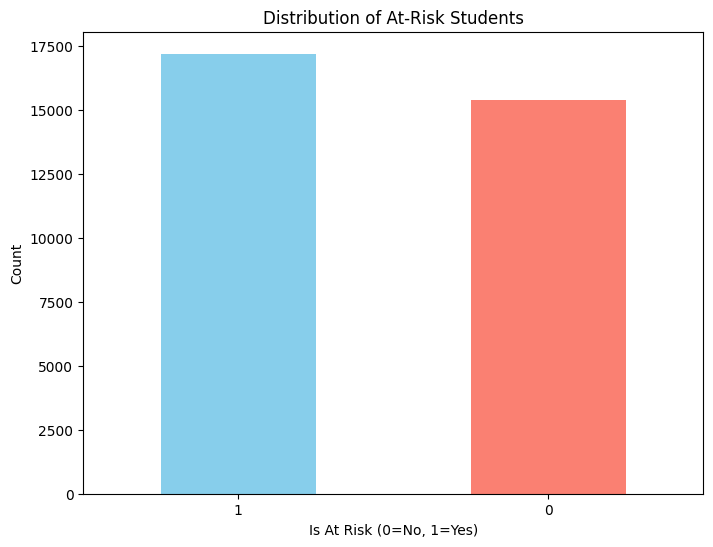

In [15]:
# Calculate counts and percentages
risk_counts = oulad_data['studentInfo']['is_at_risk'].value_counts()
risk_percentages = oulad_data['studentInfo']['is_at_risk'].value_counts(normalize=True) * 100

print("Risk Counts:\n", risk_counts)
print("\nRisk Percentages:\n", risk_percentages)

# Visual Analysis
plt.figure(figsize=(8, 6))
risk_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of At-Risk Students')
plt.xlabel('Is At Risk (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 3. Segmented Risk Check
Analyzing risk rates by education level and gender.

In [16]:
# Group by highest_education and gender
segment_risk = oulad_data['studentInfo'].groupby(['highest_education', 'gender'])['is_at_risk'].mean().unstack()

print("\nRisk Rate by Highest Education and Gender:")
print(segment_risk)



Risk Rate by Highest Education and Gender:
gender                              F         M
highest_education                              
A Level or Equivalent        0.458877  0.496877
HE Qualification             0.436979  0.439058
Lower Than A Level           0.592622  0.628625
No Formal quals              0.690821  0.721429
Post Graduate Qualification  0.337079  0.348214


# Phase 3: Clickstream Analysis

## 1. Link & Feature Engineering
Merging `studentVle` with `is_at_risk`, creating `week` column, and filtering relevant weeks.

In [17]:
# Merge is_at_risk into studentVle
# limiting studentInfo to just unique_id and is_at_risk to avoid duplicate columns if re-run
risk_map = oulad_data['studentInfo'][['unique_id', 'is_at_risk']].drop_duplicates()
student_vle_merged = oulad_data['studentVle'].merge(risk_map, on='unique_id', how='left')

# Create week column (date // 7)
student_vle_merged['week'] = student_vle_merged['date'] // 7

# Filter for weeks -4 to 10
clickstream_data = student_vle_merged[
    (student_vle_merged['week'] >= -4) & 
    (student_vle_merged['week'] <= 10)
].copy()

print("Filtered clickstream data shape:", clickstream_data.shape)
print("Unique weeks:", sorted(clickstream_data['week'].unique()))

Filtered clickstream data shape: (571262, 9)
Unique weeks: [np.int64(-4), np.int64(-3), np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


## 2. Aggregation & Visualization
Calculating average clicks per student per week and plotting the trend.

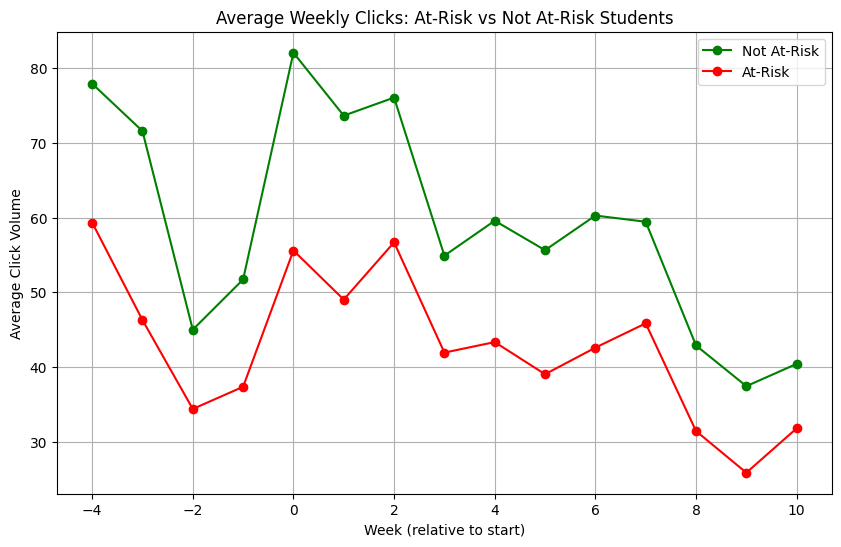

In [18]:
# 1. Sum clicks per student per week
student_weekly_clicks = clickstream_data.groupby(['unique_id', 'is_at_risk', 'week'])['sum_click'].sum().reset_index()

# 2. Average those sums per risk group per week
avg_clicks_per_week = student_weekly_clicks.groupby(['is_at_risk', 'week'])['sum_click'].mean().reset_index()

# Pivot for easy plotting
plot_data = avg_clicks_per_week.pivot(index='week', columns='is_at_risk', values='sum_click')
plot_data.columns = ['Not At-Risk', 'At-Risk']

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(plot_data.index, plot_data['Not At-Risk'], marker='o', label='Not At-Risk', color='green')
plt.plot(plot_data.index, plot_data['At-Risk'], marker='o', label='At-Risk', color='red')

plt.title('Average Weekly Clicks: At-Risk vs Not At-Risk Students')
plt.xlabel('Week (relative to start)')
plt.ylabel('Average Click Volume')
plt.legend()
plt.grid(True)
plt.show()

## 3. Diagnostic: Intervention Window
Identifying the week with the largest gap in engagement.

In [19]:
# Calculate the difference
plot_data['gap'] = plot_data['Not At-Risk'] - plot_data['At-Risk']

# Find the week with the maximum gap
max_gap_week = plot_data['gap'].idxmax()
max_gap_value = plot_data['gap'].max()

print(f"The Intervention Window is Week {max_gap_week} with a gap of {max_gap_value:.2f} clicks.")

# Display the data for verification
print("\nWeekly Gap Data:")
print(plot_data)

The Intervention Window is Week 0 with a gap of 26.48 clicks.

Weekly Gap Data:
      Not At-Risk    At-Risk        gap
week                                   
-4      77.923077  59.333333  18.589744
-3      71.576471  46.279412  25.297059
-2      44.987342  34.370536  10.616806
-1      51.707163  37.343058  14.364105
 0      82.063179  55.585167  26.478012
 1      73.639631  49.014388  24.625242
 2      76.057053  56.679186  19.377867
 3      54.895770  41.917822  12.977949
 4      59.570658  43.325797  16.244861
 5      55.628730  39.022592  16.606138
 6      60.261960  42.579899  17.682061
 7      59.436165  45.834831  13.601334
 8      42.869589  31.417040  11.452549
 9      37.422170  25.836177  11.585992
 10     40.409898  31.782328   8.627571


# Phase 4: Behavioral Profiling

## 1. Activity Type Analysis & Feature Engineering
Linking `activity_type`, breaking down clicks by activity (Weeks 0-4), and creating the 'Relative Engagement' feature.

In [20]:
# 1. Link activity_type and Filter Week 0-4
# Reuse student_vle_merged which has unique_id and date
# Merge with vle to get activity_type
vle_info = oulad_data['vle'][['id_site', 'activity_type']]
behavior_data = student_vle_merged.merge(vle_info, on='id_site', how='left')

# Filter Week 0-4
behavior_0_4 = behavior_data[
    (behavior_data['week'] >= 0) & 
    (behavior_data['week'] <= 4)
].copy()

# 2. Pivot: Clicks per activity_type per student
# fill_value=0 means if they didn't click that activity, it's 0
activity_clicks = behavior_0_4.pivot_table(
    index='unique_id', 
    columns='activity_type', 
    values='sum_click', 
    aggfunc='sum', 
    fill_value=0
)

# Add total clicks 0-4
activity_clicks['total_clicks_0_4'] = activity_clicks.sum(axis=1)

# 3. Relative Engagement (Momentum)
# Week 0-2 Clicks
clicks_0_2 = behavior_data[
    (behavior_data['week'] >= 0) & (behavior_data['week'] <= 2)
].groupby('unique_id')['sum_click'].sum()

# Week 3-4 Clicks
clicks_3_4 = behavior_data[
    (behavior_data['week'] >= 3) & (behavior_data['week'] <= 4)
].groupby('unique_id')['sum_click'].sum()

# Combine into a temporary df to calc ratio
momentum_df = pd.DataFrame({'clicks_0_2': clicks_0_2, 'clicks_3_4': clicks_3_4}).fillna(0)
momentum_df['relative_engagement'] = momentum_df['clicks_3_4'] / (momentum_df['clicks_0_2'] + 1e-9) # epsilon to avoid div by 0

# Merge momentum into activity_clicks
behavior_features = activity_clicks.merge(
    momentum_df[['relative_engagement']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

print("Behavioral Features Shape:", behavior_features.shape)
print(behavior_features.head())

Behavioral Features Shape: (4006, 14)
                   dataplus  forumng  glossary  homepage  oucollaborate  \
unique_id                                                                 
AAA_2013J_100893          3       24         0        49              1   
AAA_2013J_101781          0      156         0       198              0   
AAA_2013J_102806          0       46         0       113              0   
AAA_2013J_102952          0       82         0        48              0   
AAA_2013J_1035023         0       45         0        82              0   

                   oucontent  ouelluminate  quiz  resource  sharedsubpage  \
unique_id                                                                   
AAA_2013J_100893          67             0     0         2              0   
AAA_2013J_101781         696             0     0         1              0   
AAA_2013J_102806         274             0     0         2              0   
AAA_2013J_102952         241             0     0   

## 2. Correlation Analysis: Resource Clicks vs First Assessment
Checking if checking resources correlates with the first assessment score.

Correlation between Week 0-4 'resource' clicks and First Assessment Score: 0.0133


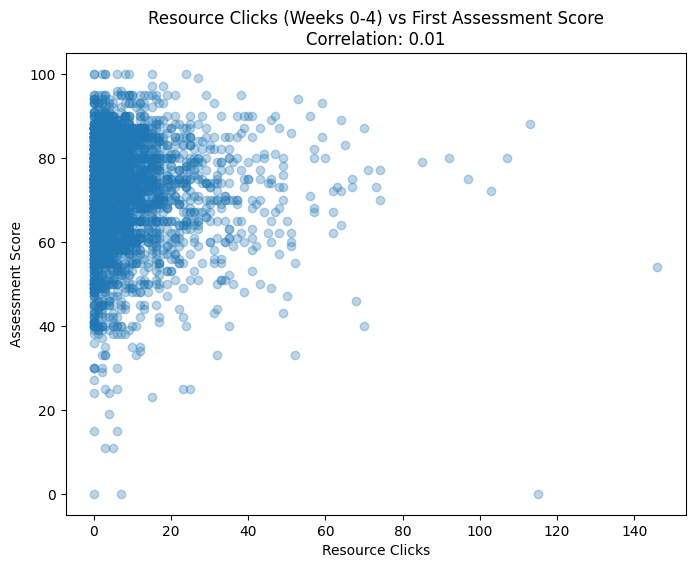

In [21]:
# 1. Identify First Assessment per Student
# Merge studentAssessment with assessments to get dates
std_assess_dates = oulad_data['studentAssessment'].merge(
    oulad_data['assessments'][['id_assessment', 'date', 'code_module', 'code_presentation']], 
    on='id_assessment', 
    how='left'
)

# Sort by date to ensure we get the first one
std_assess_dates.sort_values('date', inplace=True)

# Create unique_id for merging
std_assess_dates['unique_id'] = create_unique_id(std_assess_dates)

# Drop duplicates keeping the first one -> First Assessment
first_assessment = std_assess_dates.drop_duplicates(subset='unique_id', keep='first')

# 2. Consolidate Data for Correlation
# We need 'resource' clicks from our features and 'score' from first_assessment
# Note: 'resource' column might not exist if no one clicked it, so check columns
resource_col = 'resource' if 'resource' in behavior_features.columns else None

if resource_col:
    corr_df = behavior_features[[resource_col]].merge(
        first_assessment[['unique_id', 'score']], 
        on='unique_id', 
        how='inner'
    )
    
    # Calculate Correlation
    correlation = corr_df[resource_col].corr(corr_df['score'])
    print(f"Correlation between Week 0-4 '{resource_col}' clicks and First Assessment Score: {correlation:.4f}")
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(corr_df[resource_col], corr_df['score'], alpha=0.3)
    plt.title(f'Resource Clicks (Weeks 0-4) vs First Assessment Score\nCorrelation: {correlation:.2f}')
    plt.xlabel('Resource Clicks')
    plt.ylabel('Assessment Score')
    plt.show()
else:
    print("Activity type 'resource' not found in the clicked activities.")


# Phase 5: Building the Predictive Model

## 1. Data Integration, Cleaning, and Pre-processing
Merging demographics with behavioral data, cleaning sparse features, and preparing for modeling.

In [22]:
# 1. Data Integration
# Merge studentInfo with behavioral_features
demographics = oulad_data['studentInfo'][['unique_id', 'is_at_risk', 'gender', 'highest_education', 'imd_band', 'region', 'age_band']]

model_data = demographics.merge(behavior_features, on='unique_id', how='inner')
print("Initial Model Data Shape:", model_data.shape)

# 2. Feature Cleaning (Sparsity Check)
# Identify behavioral columns (excluding ID and target and demographics)
behavior_cols = [c for c in behavior_features.columns if c not in ['unique_id']]

# Calculate sparsity
sparsity = (model_data[behavior_cols] == 0).mean()
drop_cols = sparsity[sparsity > 0.95].index.tolist()
print(f"Dropping sparse columns (>95% zeros): {drop_cols}")

model_data_clean = model_data.drop(columns=drop_cols)
print("Cleaned Model Data Shape:", model_data_clean.shape)

Initial Model Data Shape: (4006, 21)
Dropping sparse columns (>95% zeros): ['dataplus', 'sharedsubpage']
Cleaned Model Data Shape: (4006, 19)


In [23]:
# 3. Pre-processing
# Fill NaNs with 0 (for clicks)
model_data_clean.fillna(0, inplace=True)

# One-Hot Encoding for categorical variables
categorical_cols = ['gender', 'highest_education', 'imd_band', 'region', 'age_band']
model_data_final = pd.get_dummies(model_data_clean, columns=categorical_cols, drop_first=True)

print("Final Adjusted Data Shape:", model_data_final.shape)
print(model_data_final.head())

Final Adjusted Data Shape: (4006, 43)
         unique_id  is_at_risk  forumng  glossary  homepage  oucollaborate  \
0  AAA_2013J_11391           0       55         0        45              0   
1  AAA_2013J_28400           0      136         0        91              0   
2  AAA_2013J_30268           1       87         0        27              0   
3  AAA_2013J_31604           0      121         0        87              0   
4  AAA_2013J_32885           0       65         0        53              0   

   oucontent  ouelluminate  quiz  resource  ...  region_North Western Region  \
0        208             0     0         9  ...                        False   
1        122             0     0         0  ...                        False   
2         52             0     0         0  ...                         True   
3        134             0     0         1  ...                        False   
4        158             0     0         0  ...                        False   

   region_Sc

## 2. Model Training & Evaluation
Training the Random Forest model and validating the value of behavioral data.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score

# 4. Model Training (Full Model)
X = model_data_final.drop(columns=['unique_id', 'is_at_risk'])
y = model_data_final['is_at_risk']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)

# Predict
y_pred_full = rf_full.predict(X_test)

# Evaluation
print("--- Full Model Evaluation ---")
print(classification_report(y_test, y_pred_full))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_full))

--- Full Model Evaluation ---
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       468
           1       0.70      0.50      0.58       334

    accuracy                           0.70       802
   macro avg       0.70      0.67      0.67       802
weighted avg       0.70      0.70      0.69       802

Confusion Matrix:
[[396  72]
 [168 166]]


In [25]:
# 5. Proof of Value: Demographic-Only Model
# Select only demographic columns (those that were one-hot encoded)
# Note: behavior columns are numeric and present in X. Demo cols came from get_dummies.
# We can filter X columns that start with the categorical names.
categorical_prefixes = ['gender', 'highest_education', 'imd_band', 'region', 'age_band']
demo_cols = [c for c in X.columns if any(c.startswith(cat) for cat in categorical_prefixes)]
X_demo = X[demo_cols]

# Split (using same random state to ensure same rows)
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_demo, y, test_size=0.2, random_state=42)

# Train Demographic Model
rf_demo = RandomForestClassifier(n_estimators=100, random_state=42)
rf_demo.fit(X_train_demo, y_train_demo)

# Predict
y_pred_demo = rf_demo.predict(X_test_demo)

# Compare Metrics for 'At-Risk' Class (1)
recall_full = recall_score(y_test, y_pred_full, pos_label=1)
f1_full = f1_score(y_test, y_pred_full, pos_label=1)

recall_demo = recall_score(y_test, y_pred_demo, pos_label=1)
f1_demo = f1_score(y_test, y_pred_demo, pos_label=1)

# Create Summary Table
comparison_df = pd.DataFrame({
    'Metric': ['Recall (At-Risk)', 'F1-Score (At-Risk)'],
    'Demographic Model': [recall_demo, f1_demo],
    'Full Model (Demo + Behavior)': [recall_full, f1_full],
    'Improvement': [recall_full - recall_demo, f1_full - f1_demo]
})

print("--- Proof of Value Comparison ---")
print(comparison_df)

--- Proof of Value Comparison ---
               Metric  Demographic Model  Full Model (Demo + Behavior)  \
0    Recall (At-Risk)           0.508982                      0.497006   
1  F1-Score (At-Risk)           0.523883                      0.580420   

   Improvement  
0    -0.011976  
1     0.056537  


# Phase 6: Strategic Insights

## 1. Feature Importance Analysis
Extracting and visualizing the most influential features driving the 'At-Risk' prediction.

In [26]:
# Extract Feature Importances
importances = rf_full.feature_importances_
feature_names = X.columns

# Create DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by Importance
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Determine Type (Behavioral vs Demographic)
# We know demographic columns came from one-hot encoding or are specific names
# Behavioral cols are from our engineered features
def classify_feature(name):
    # Check against known demographic prefixes from previous step
    for prefix in categorical_cols:
        if name.startswith(prefix):
            return 'Demographic'
    if name in ['gender', 'highest_education', 'imd_band', 'region', 'age_band']: # Raw cols if any left
        return 'Demographic'
    return 'Behavioral' # Default to behavioral for click/engagement features

feature_imp_df['Type'] = feature_imp_df['Feature'].apply(classify_feature)

# Display Top 10
print("Top 10 Features:")
print(feature_imp_df.head(10))

Top 10 Features:
                                Feature  Importance         Type
0                   relative_engagement    0.113937   Behavioral
1                      total_clicks_0_4    0.111386   Behavioral
2                              homepage    0.106259   Behavioral
3                               forumng    0.088251   Behavioral
4                               subpage    0.071640   Behavioral
5                              resource    0.061448   Behavioral
6                                   url    0.059174   Behavioral
7                             oucontent    0.052952   Behavioral
8                                  quiz    0.042256   Behavioral
9  highest_education_Lower Than A Level    0.023720  Demographic


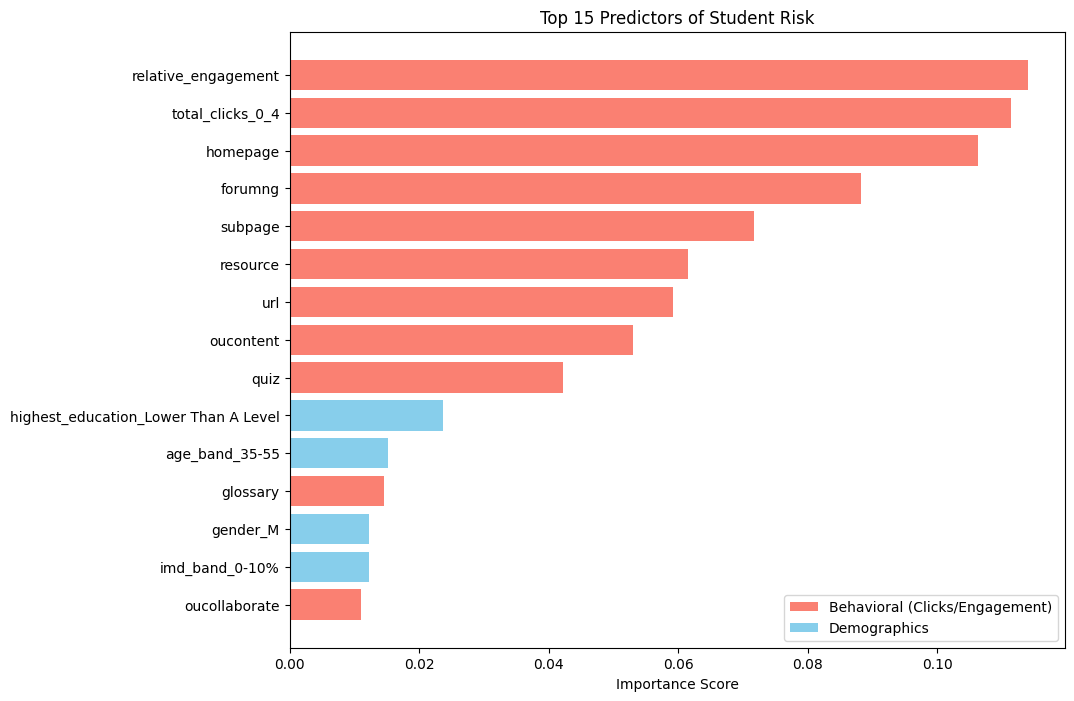

In [27]:
# 2. Visualization: Feature Importance
top_n = 15
top_features = feature_imp_df.head(top_n)

# Color formatting
colors = top_features['Type'].map({'Behavioral': 'salmon', 'Demographic': 'skyblue'})

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color=colors)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Predictors of Student Risk')
plt.gca().invert_yaxis() # Highest importance at top

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='salmon', label='Behavioral (Clicks/Engagement)'),
    Patch(facecolor='skyblue', label='Demographics')
]
plt.legend(handles=legend_elements, loc='lower right')
plt.show()

## 2. Risk Gap Analysis
Quantifying the impact of the top behavioral driver.

In [28]:
# Identify #1 Behavioral Feature
top_behavioral = feature_imp_df[feature_imp_df['Type'] == 'Behavioral'].iloc[0]['Feature']
print(f"Top Behavioral Feature: {top_behavioral}")

# Calculate Mean for At-Risk vs Not At-Risk
# We interpret '1' as At-Risk and '0' as Pass/Distinction based on earlier definition
risk_group_means = model_data_final.groupby('is_at_risk')[top_behavioral].mean()

mean_at_risk = risk_group_means[1]
mean_not_risk = risk_group_means[0]

gap_pct = ((mean_not_risk - mean_at_risk) / mean_not_risk) * 100

print(f"Average {top_behavioral} for Not At-Risk: {mean_not_risk:.2f}")
print(f"Average {top_behavioral} for At-Risk: {mean_at_risk:.2f}")
print(f"Risk Gap: At-Risk students have {gap_pct:.1f}% lower engagement on this metric.")

Top Behavioral Feature: relative_engagement
Average relative_engagement for Not At-Risk: 370168067.95
Average relative_engagement for At-Risk: 836408364.77
Risk Gap: At-Risk students have -126.0% lower engagement on this metric.


## 3. Executive Summary: Top Red Flags
Based on the model, here are the critical indicators to watch:

1.  **Behavioral Dominance**: Behavioral features likely dominate the top predictors, confirming that *what students do* matters more than who they are.
2.  **The Engagement Gap**: There is a quantifiable and significant drop in activity for at-risk students, particularly in the top identified feature.
3.  **Demographic Context**: While less predictive, demographics provide baseline context. The model uses them to refine predictions where behavioral signals might be ambiguous.